## Evaluate Quality Data

### Import Libraries

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt 
import obspy 


from pandas import read_csv, DataFrame, Series
from tqdm import tqdm
from andbro__save_to import __save_to
from andbro__savefig import __savefig

from andbro__fft import __fft


### Define Methods

In [2]:

def __archive_request(seed_id, tstart, tdelta, raw=None):
    
    ''' get data of ROMY for one component from archive 

    VARIABLES:
        seed_id:    code of seismic stations (e.g. "BW.ROMY..BJU")
        tstart:	    begin of time period
        tdelta:     temporal length of period

    DEPENDENCIES:
        import obspy

    EXAMPLE:
        >>> __get_stream_data_archive('BW.ROMY.10.BJZ', '2020-07-17 02:50', 3600, raw=False)

    '''
    from obspy.clients.fdsn import Client

    
    def __extend_digits(doy):
        if doy < 10:
            doy = f"00{doy}"
        elif doy >= 10 and doy < 100:
            doy = f"0{doy}"
        return doy 
    
    
    net, sta, loc, cha = seed_id.split(".")
    
    ## defining parameters
    year = tstart.year
    doy  = tstart.julday
    tend = tstart + tdelta
    
    doy = __extend_digits(doy)
    
    ## define station depending if raw is set or not
#     sta = sta if raw is None else f"D{sta}"

    ## define local data path
    pathroot = "/import/freenas-ffb-01-data/romy_archive/"

    ## __________________________________________________________________________
    
    try:
        route = obspy.clients.fdsn.RoutingClient("eida-routing")
        inv   = client.get_stations(network=net, station=sta, level="response")
#         print("  --> inventory was obtained"); obtained_inventory=True

    except:
        if raw is not True:
            print("  --> inventory could not be obtained..."); obtained_inventory=False
    
    ## -------------------------- ##
    if raw is None or raw is False:
        ## recreate file structure of archive
        path = f"{pathroot}{year}/{net}/{sta}/{cha}.D/"
        name = f"{net}.{sta}.{loc}.{cha}.D.{year}.{doy}"
        ## get stream data
        st = obspy.read(path+name, starttime=tstart, endtime= tend)
        
        if obtained_inventory:
            print("  --> trend and response is being removed...")
            return st.detrend("linear").remove_response(inventory=inv) 
        else:
            return st   

    ## -------------------------- ##
    elif raw is True: 
        if sta == "ROMY":
            ## recreate file structure of archive
            path = f"{pathroot}{year}/{net}/DROMY/FJ{cha[2]}.D/"
            name = f"{net}.D{sta}..F{cha[1:3]}.D.{year}.{doy}"
            ## get stream data
            st = obspy.read(path+name, starttime=tstart, endtime= tend)
            return st
        else:
            print("  --> something went wrong! perhaps with seed_id?")


### Configurations

In [3]:
path = '/home/andbro/Documents/ROMY/QualityCheck/'
# path = '/scratch/brotzer/'

path_add = "runw/"

path = path+path_add

In [4]:
## interactively 
if len(sys.argv) == 4:
    date_to_analyse = sys.argv[1]
    channel = sys.argv[2]
    path = sys.argv[3]
else:
    date_to_analyse = input("\n Enter the date (e.g. 2019-05-14):  "); print("\n")
    channel = input("\n Enter the channel:  "); print("\n")



date_to_analyse = obspy.UTCDateTime(date_to_analyse)

## setting input paths and files automatically
ipath = f'{path}Qfiles/{str(date_to_analyse)[:7]}/'
ifile = f'{date_to_analyse.date}.Q{channel[-1]}'

opath = f'{path}Cfiles/{str(date_to_analyse)[:7]}/'
ofile = f'{date_to_analyse.date}.C{channel[-1]}'

opathfigs = f'{path}QPlots/{str(date_to_analyse)[:7]}/{channel}/'
onamefigs = f'ROMY_{date_to_analyse.date}_Q{channel[-1]}plots'


global date; date = ifile[:10]

global component; component = f"{channel[2]}-Component"



# if not os.path.isfile(ipath+ifile):
#     print(f"\nNo input file found: {ipath+ifile}")
#     sys.exit()


 Enter the date (e.g. 2019-05-14):  2019-11-28



 Enter the channel:  BJW





### Load Data

The Qfile for this channel and day is loaded. The mean (=average) values are converted (1e6 count/volt). 1st order time derivative of mean and difference of max. AC/DC and min. AC/DC is calculated.  

The data frame is then sorted and checked for doubles. 

In [5]:
## get header information
qfile = open(ipath+ifile, 'r')
line = qfile.readline()
qfile.close()

## extract parameters
win, subwin, overlap = int(line.split(" ")[2]), int(line.split(" ")[4]), float(line.split(" ")[6])

## define time delta
dt = overlap*subwin
dt

1.0

In [6]:
## read data from file to dataframe
data = read_csv(ipath+ifile, delimiter=" ", header=1)


## convert counts to volts 
data.average   = data.average*0.59604645e-6  ## obsidian counts to volt
data.delta_max = data.delta_max*0.59604645e-6  ## obsidian counts to volt
data.delta_min = data.delta_min*0.59604645e-6  ## obsidian counts to volt
data.avar      = data.avar*0.59604645e-6  ## obsidian counts to volt


## add data colmuns
# data['diff'] = (data.delta_max - data.delta_min)/data.average
data['diff'] = (data.delta_max - data.delta_min)

## add finite-difference derivative for average
# data.daverage = data.daverage/max(data.daverage)
data['daverage'] = (data.average.diff(1)/dt).abs()

## add contrast measure
data['contrast'] = abs(abs(data.delta_max) - abs(data.delta_min)) / (abs(data.delta_min) + abs(data.delta_max))
data['dcontrast'] = (data.contrast.diff(1)/dt).abs()

## sort data frame in case any mixup occured
data = data.sort_values(by=['seconds'], ascending=True, axis=0)

## check for doubles 
doubles = 0
if data.seconds.duplicated().any():
    doubles +=1
print(f"\n{doubles} doubles found\n")

## show dataframe
data


0 doubles found



,sample_id,seconds,average,avar,delta_max,delta_min,frequency,diff,daverage,contrast,dcontrast
45,50000.0,10.0,1.260223,0.010940,1.292853,1.226944,881.750,0.065909,0.004483,0.026156,0.000500
46,150000.0,30.0,1.260418,0.017527,1.295873,1.227993,882.375,0.067880,0.000195,0.026895,0.000739
47,250000.0,50.0,1.260109,0.009598,1.293300,1.225303,882.500,0.067998,0.000309,0.026998,0.000103
48,350000.0,70.0,1.260358,0.013291,1.292888,1.227589,878.000,0.065299,0.000249,0.025907,0.001091
49,450000.0,90.0,1.259929,0.013554,1.293518,1.226561,870.125,0.066957,0.000429,0.026569,0.000662
...,...,...,...,...,...,...,...,...,...,...,...
4315,431545000.0,86309.0,1.187099,0.014713,2.135044,0.259565,451.750,1.875480,0.000820,0.783209,0.000289
4316,431645000.0,86329.0,1.187350,0.011808,2.135099,0.259808,451.750,1.875291,0.000251,0.783033,0.000176
4317,431745000.0,86349.0,1.187573,0.010041,2.136897,0.258817,451.750,1.878080,0.000223,0.783933,0.000900
4318,431845000.0,86369.0,1.187437,0.020678,2.134882,0.259130,451.750,1.875752,0.000135,0.783518,0.000415


### Evaluate Data

Several cirteria determine if the sampled averaged windows are of good quality (Q0), medium Quality (Q1) or bad quality (Q2). 

1) if mean value (=DC) is below 0.1 -> Q2 

2) if time derivative of mean is above 3*std() -> Q2 (outlieres/sudden jumps)

3) if frequency is outside an intervall of 1.2 Hz around an specified expected frequency for each ring -> Q2


4) if standard deviation of the mean is above 3*std() -> Q1

5) AC/DC ratio is below a threshold of 1 -> Q1 

6) time derivative of AC/DC is above 3*std() -> Q1

In [7]:
## __________________________________
## criterion concerning the time derivative of median
avg_crt_lower = 0.1

data['quality'] = np.where(abs(data['average']) > avg_crt_lower, 0, 2)


avg_crt_upper = 2

data['quality'] = np.where(abs(data['average']) > avg_crt_upper, 1, data['quality'])


## __________________________________
## criterion concerning the time derivative of median
    
davg_crt = 0.05
    
data['quality'] = np.where((data['quality'] < 2)  & (data['daverage'] > davg_crt), 2, data['quality'])



## __________________________________
## criteria concerning the estiamted frequency

off = 1.5

# fsagnac = {'fz':553.4, 'fu':303.0, 'fv':447.5, 'fw':448.0} # V1
fsagnac = {'fz':553.4, 'fu':303.0, 'fv':447.5, 'fw':451.7} # V2

if channel[2] == "Z":
    f1_crt, f2_crt = fsagnac['fz']-off, fsagnac['fz']+off

elif channel[2] == "U": 
    f1_crt, f2_crt = fsagnac['fu']-off, fsagnac['fu']+off
    
elif channel[2] == "V":
    f1_crt, f2_crt = fsagnac['fv']-off, fsagnac['fv']+off

elif channel[2] == "W":
    f1_crt, f2_crt = fsagnac['fw']-off, fsagnac['fw']+off    

## apply criteria
data['quality'] = np.where((data['frequency'] < f2_crt) & (data['frequency'] > f1_crt), data['quality'], 2)


## additional criteria where single Q2 are removed to avoid random frequency hits
ind = [idx for idx, col in enumerate(data.columns) if col == "quality"]; ind = ind[0]
for i in range(1,len(data.seconds)-1):
    if data.quality.iloc[i-1] == 2 and data.quality.iloc[i+1] == 2 and data.quality.iloc[i] != 2:
        data.iloc[i,ind] = 2
        

## __________________________________
## contrast 

cont_crt = 0.08

data['quality'] = np.where((data['quality'] < 2) & (data['contrast'] < cont_crt), 2, data['quality'])


# cont_crt_q1 = 0.5

# data['quality'] = np.where((data['quality'] < 2) & (data['contrast'] < cont_crt_q1), 1, data['quality'])



## __________________________________
## difference of relative amplitudes

avar_crt = 0.3

data['quality'] = np.where((data['quality'] < 1) & (data['avar'] > avar_crt), 1, data['quality'])




## __________________________________
## difference of relative amplitudes

# amp_crt = data['diff'].median() + 3*data['diff'].std() 
# amp_crt = 0.3

# data['quality'] = np.where((data['quality'] < 1) & (data['diff'] > amp_crt) , 1, data['quality'])






## check for changes in quality for ample coloring
data['gaps'] = data.quality.diff()

## exchane NaN (due to diff) for 1.0 
ind_gaps = [idx for idx, col in enumerate(data.columns) if col == "gaps"]; ind_gaps = ind_gaps[0]
print(ind_gaps)
data.iloc[0, ind_gaps] = 1.0


## __________________________________
##

# print(f"{ifile[:10]}\n\n Q0: {round(a*100,2)}%\n Q1: {round(b*100,2)}%\n Q2: {round(d*100,2)}%\n Q3: {round(c*100,2)}%")
qlevel = np.unique(data.quality, return_counts=True)
print(f"{ifile[:10]}: total={len(data)}")
for j in range(len(qlevel[0])):
    print(f"Q{qlevel[0][j]}:  {round(qlevel[1][j]/len(data.quality)*100, 2)}%") 

    
# ## select good quality data
data_select  = data[(data['quality'] == 0) | (data['quality'] == 1)]
data_quality = data[(data['gaps'] != 0)]

## always add last row to selection
data_quality = data_quality.append(data.iloc[-1][:])


## special case when all data is Q2
sucks = False
if data_select.empty:
    print("fuck, all data sucks!")
    sucks = True
#     sys.exit


12
2019-11-28: total=4320
Q0:  57.52%
Q1:  0.16%
Q2:  42.31%


### Store thresholds

In [8]:
import pickle

thresholds = {
              'crt_avg_upper':avg_crt_upper,
              'crt_avg_lower':avg_crt_lower,
              'crt_davg':davg_crt,
              'crt_freq':off,
              'crt_avar':avar_crt,
              'fsagnac':fsagnac,
              'crt_cont':cont_crt,
             }

outfile_thres = open("thresholds.pick", "wb")
pickle.dump(thresholds, outfile_thres)
outfile_thres.close()

### Write log file of quality 

In [9]:

Q0_num, Q1_num, Q2_num = 0, 0, 0
if 0 in qlevel[0]:
    ind = list(qlevel[0]).index(0)
    Q0_num = qlevel[1][ind]
if 1 in qlevel[0]:
    ind = list(qlevel[0]).index(1)
    Q1_num = qlevel[1][ind]
if 2 in qlevel[0]:
    ind = list(qlevel[0]).index(2)
    Q2_num = qlevel[1][ind]
    
logfile =  open(opath+f'{date_to_analyse.year}-{date_to_analyse.month}_quality.log', 'a+')
logfile.write(f"{date_to_analyse.date} {len(data.quality)} {Q0_num} {Q1_num} {Q2_num}\n")
logfile.close()


### Contribution to quality of entire year 

In [10]:
iname2 = f"{date_to_analyse.year}_{channel}_overview"

## check if file exists otherwise create it and write header
if not os.path.isfile(ipath+"../../"+iname2):
    with open(ipath+"../../"+iname2, 'w') as f:
        f.write('date,doy,total_samples,Q0,Q1,Q2,dt_med,frequency_med,dt_difference_of_ratios,bad_areas,contrast,dcontrast')
    
## read file with overview values
Qoverview = read_csv(ipath+"../../"+iname2, header=0, delimiter=",")

len1=Qoverview.doy.size

## amount of areas with Q2
count_q2 = data_select.gaps[abs(data_select.gaps)>1].count()

## add values to dataframe and overwrite if date already exists
if sucks:
     new_row = [str(date_to_analyse.date), 
               date_to_analyse.julday, 
               len(data), 
               Q0_num, 
               Q1_num, 
               Q2_num, 
               np.nan, 
               np.nan, 
               np.nan,
               count_q2,
               np.nan,
               np.nan,
              ]   
    
else:
    new_row = [str(date_to_analyse.date), 
               date_to_analyse.julday, 
               len(data), 
               Q0_num, 
               Q1_num, 
               Q2_num, 
               np.median(data_select.daverage), 
               np.median(data_select.frequency), 
               np.median(data_select['diff']),
               count_q2,
               np.median(data_select.contrast),
               np.median(data_select.dcontrast),
              ]


idx = Qoverview[Qoverview.doy == date_to_analyse.julday].index.tolist()

if len(idx) == 0:
    Qoverview.loc[len(Qoverview.index)] = new_row
else:
    Qoverview.loc[Qoverview.index==idx[0]] = new_row

## sort dataframe
Qoverview = Qoverview.sort_values(by=['doy'], axis=0, ascending=True)

len2=Qoverview.doy.size

if len1 == len2:
    print(f"\nline in {date_to_analyse.year}_{channel}_overview has been exchanged!")
elif abs(len1 - len2) == 1:
    print(f"\nline in {date_to_analyse.year}_{channel}_overview has been added!")
else:
    print(f"\nan expception occurred! -> length before: {len1} and after: {len2}")
    
## write dataframe back to file
Qoverview.to_csv(ipath+"../../"+iname2, header=True, index=False)


line in 2019_BJW_overview has been added!


### Writing data to Cfile

In [11]:
## create output file and add header
# if not os.path.isdir(opath):
#     os.mkdir(opath)

print(f"\n writing {opath}{ofile} ... \n")
data_quality.to_csv(f'{opath}{ofile}', header=True, index=False, columns=['seconds','quality'])



 writing /home/andbro/Documents/ROMY/QualityCheck/runw/Cfiles/2019-11/2019-11-28.CW ... 



### Plotting

In [12]:

def __plot_quality(data, data_quality, criteria=None, limit=False):

    t1 = "00:00"
    t2 = "24:00"
    
    
    ## calulcate difference in samples from first and second row in dataframe
    idx1 = data[data['sample_id'] == data.sample_id.iloc[0]].index[0]
    idx2 = data[data['sample_id'] == data.sample_id.iloc[1]].index[0]
    steps = int(abs(data.sample_id.iloc[0]-data.sample_id.iloc[1])/(idx2-idx1))

    ## plotting 
    fig, axes = plt.subplots(6, 1, figsize=(15,12), sharex='all')

    fig.subplots_adjust(hspace=0.2)

    fs=14

    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.average

    if limit:
        # axes[0].scatter(xdata, ydata, s=35, label='mean', color="darkblue", edgecolor="black", zorder=3)
        axes[0].errorbar(xdata, ydata, yerr=data.sigma, label='mean', ecolor='grey', markeredgewidth=0.1 ,fmt="ok", capsize=5)
        axes[0].plot(xdata, ydata, 'k--')
    else:
        axes[0].plot(xdata, ydata, 'k-', label='mean')

    
    axes[0].legend(fontsize=fs, loc="upper left")
    axes[0].tick_params(axis='both', labelsize=fs)
    axes[0].set_xlim(0,24)
    axes[0].set_ylabel("Amp.(V)", fontsize=fs)
    
    if criteria:
        axes[0].set_title(f"Raw data of {component} on {date} with thresholds", fontsize=fs+3)
    else:
        axes[0].set_title(f"Raw data of {component} on {date} after selection", fontsize=fs+3)
    
    ## _______________________________________________________________________________
    xdata, ydata  = data.seconds/3600, data.daverage

    if limit:
        axes[1].scatter(xdata, ydata, s=35, label='dt_mean', color="red", edgecolor="black", linewidth=0.5 ,zorder=3)
#         axes[1].plot(xdata, ydata, 'k--')
    else:
        axes[1].plot(xdata, ydata, 'r-', label='dt_mean') 
        
    if criteria:
#         axes[1].plot(xdata, np.ones(len(ydata))*davg_crt, color='darkgrey', linestyle="--", label=f'{round(davg_crt,3)}', zorder=-1)
        axes[1].plot(xdata, np.ones(len(ydata))*davg_crt_Q1, color='darkgrey', linestyle="--", label=f'Q1: {round(davg_crt_Q1,3)}', zorder=-1)
        axes[1].plot(xdata, np.ones(len(ydata))*davg_crt_Q2, color='darkgrey', linestyle="--", label=f'Q2: {round(davg_crt_Q2,3)}', zorder=-1)

        
    axes[1].legend(fontsize=fs, loc="upper left")
    axes[1].tick_params(axis='both', labelsize=fs)
    axes[1].set_xlim(0,24)
    axes[1].set_ylabel("Amp. rate (V/s)", fontsize=fs)



    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.sigma

    if limit:
        axes[2].scatter(xdata, ydata, s=35, label='std', color="darkorange", edgecolor="black", linewidth=0.5 ,zorder=3)
#         axes[2].plot(xdata, ydata, 'k--')
    else:
        axes[2].plot(xdata, ydata, color='darkorange', label='std')

    if criteria: 
        axes[2].plot(xdata, np.ones(len(ydata))*sigma_crt, color='darkgrey', linestyle="--", label=f'{round(sigma_crt,1)}', zorder=-1)
#         axes[2].plot(xdata, np.ones(len(ydata))*np.median(ydata), color='darkgrey', linestyle="--", label='median')

    axes[2].legend(fontsize=fs, loc="upper left")
    axes[2].tick_params(axis='both', labelsize=fs)
    axes[2].set_xlim(0,24)
    axes[2].set_ylabel(r"$\sigma$ (V)", fontsize=fs)



    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.frequency

    if limit:
        axes[3].scatter(xdata, ydata, s=35, label='frequency', color="green", edgecolor="black", linewidth=0.5 ,zorder=3)
#         axes[3].plot(xdata, ydata, 'k--')
    else:
        axes[3].plot(xdata, ydata, color='green', label='frequency')
    
    if criteria:
        axes[3].plot(xdata, np.ones(len(ydata))*f1_crt, color='darkgrey', linestyle="--", label=f'{round(f1_crt,2)}', zorder=-1)
        axes[3].plot(xdata, np.ones(len(ydata))*f2_crt, color='darkgrey', linestyle="--", label=f'{round(f2_crt, 2)}', zorder=-1)


    axes[3].legend(fontsize=fs, loc="upper left")
    axes[3].tick_params(axis='both', labelsize=fs)
    axes[3].set_xlim(0,24)
    axes[3].set_ylabel("Frequency (Hz)", fontsize=fs)
   
  
    
#     if np.median(ydata) < f2_crt and np.median(ydata) > f1_crt:
#         axes[3].set_ylim(np.median(ydata) - 1e-1*np.median(ydata), np.median(ydata) + 1e-1*np.median(ydata))


    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.delta_max/data.average
    if limit:
        axes[4].scatter(xdata, ydata, s=8, label=r'A$_{pp}$ max', color="darkblue", zorder=3)
#         axes[4].plot(xdata, ydata, 'k--')
    else:
        axes[4].plot(xdata, ydata, color='darkblue', label=r'A$_{pp}$ max')

    xdata, ydata = data.seconds/3600, data.delta_min/data.average
    if limit:
        axes[4].scatter(xdata, ydata, s=8, label=r'A$_{pp}$ min', color="darkred", zorder=3)
#         axes[4].plot(xdata, ydata, 'k--'), linewidth=0
    else:
        axes[4].plot(xdata, ydata, color='darkred', label=r'A$_{pp}$ min')
   
    if criteria:
        axes[4].plot(xdata, np.ones(len(ydata))*ratio_crt, color='darkgrey', linestyle="--", label=f'{round(ratio_crt,1)}', zorder=-1)
    

    axes[4].legend(fontsize=fs, loc="upper left")
    axes[4].tick_params(axis='both', labelsize=fs)
    axes[4].set_xlim(0,24)
    axes[4].set_ylabel("Amp. (V)", fontsize=fs)


    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, (data.delta_max-data.delta_min)/data.average
    if limit:
        axes[5].scatter(xdata, ydata, s=8, label=r'$\Delta$ A$_{pp}$', color="purple", zorder=3)
#         axes[5].plot(xdata, ydata, 'k--')
    else:
        axes[5].plot(xdata, ydata, color="purple", label=r'$\Delta$ A$_{pp}$')

    if criteria:
        axes[5].plot(xdata, np.ones(len(ydata))*amp_crt, color='darkgrey', linestyle="--", label=f'{round(amp_crt,3)}', zorder=-1)

#     corners=axes[5].get_position()
#     axes[5].text(corners.x1,corners.y1,f'median: {round(np.median(ydata),2)}', 
#                  fontsize=fs, color='k', bbox=dict(facecolor='white', alpha=0.5),)

    axes[5].legend(fontsize=fs, loc="upper left")
    axes[5].tick_params(axis='both', labelsize=fs)
    axes[5].set_xlabel("Time (hours)", fontsize=fs)
    axes[5].set_ylabel("Amp. (V)", fontsize=fs)
    axes[5].set_xlim(0,24)
    
    
    
    if limit:
        plt.xlim((int(t1[:2])*3600 + int(t1[3:5]))/3600,(int(t2[:2])*3600 + int(t2[3:5]))/3600)
    else:
        axes[5].set_xticks(np.arange(0,25,2))
        axes[5].set_xticklabels(np.arange(0,25,2))

        
    ## Add colored areas indicating quality    
#     data3=data[(data['gaps'] != 0) | (data.seconds == 86370.0)]
    data3=data_quality
    
    for i in range(len(data3)-1): 
#     print(data3.iloc[i, 1], data3.iloc[i+1, 1])     
    

        if data3.iloc[i,9] == 0:
            for h in range(6):
                axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='green' ,alpha=0.4, lw=0.001, edgecolor=None);  
        if data3.iloc[i,9] == 1:
            for h in range(6):
                axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='yellow' ,alpha=0.5, lw=0.001, edgecolor=None);  
        if data3.iloc[i,9] == 2:
            for h in range(6):
                axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='darkred' ,alpha=0.5, lw=0.001, edgecolor=None);  
#         if data3.iloc[i,9] == 3:
#             for h in range(6):
#                 axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='darkred' ,alpha=0.3, lw=0.001, edgecolor=None);     

    
#     plt.show();
    return fig


In [13]:

def __plot_quality_V2(data, data_quality, criteria=None, limit=False):

    t1 = "00:00"
    t2 = "24:00"
    
    
    ## calulcate difference in samples from first and second row in dataframe
    idx1 = data[data['sample_id'] == data.sample_id.iloc[0]].index[0]
    idx2 = data[data['sample_id'] == data.sample_id.iloc[1]].index[0]
    steps = int(abs(data.sample_id.iloc[0]-data.sample_id.iloc[1])/(idx2-idx1))

    
    
    
    ## plotting 
    N = 6
    
    fig, axes = plt.subplots(N, 1, figsize=(15,12), sharex='all')

    fig.subplots_adjust(hspace=0.2)

    fs=14

    bbox = dict(boxstyle="round", fc="white")

    
    for k in range(N):
    
        ## _______________________________________________________________________________
        if k == 0:
            xdata, ydata = data.seconds/3600, data.average

            if limit:
#                 axes[k].errorbar(xdata, ydata, yerr=data.sigma, label='mean', ecolor='grey', markeredgewidth=0.1 ,fmt="ok", capsize=5)
                axes[k].scatter(xdata, ydata, s=25, color="black", edgecolor="black", linewidth=0.5 ,zorder=3)
                axes[k].plot(xdata, ydata, 'k--')
            else:
                axes[k].plot(xdata, ydata, 'k-', label='M')

                
            axes[k].annotate('A', xy=(1.00, 0.93), xycoords='axes fraction', bbox=bbox, fontsize=fs+1)

            axes[k].tick_params(axis='both', labelsize=fs)
            axes[k].set_xlim(0,24)
            axes[k].set_ylabel("M (V)", fontsize=fs)

            if criteria:
                axes[k].set_title(f"ROMY {component} on {date} with thresholds", fontsize=fs+3)
            else:
                axes[k].set_title(f"ROMY {component} on {date} after selection", fontsize=fs+3)

        ## _______________________________________________________________________________
        if k ==1:
            xdata, ydata  = data.seconds/3600, data.daverage

            if limit:
                axes[k].scatter(xdata, ydata, s=25, color="red", edgecolor="black", linewidth=0.5 ,zorder=3)
            else:
                axes[k].plot(xdata, ydata, 'r-') 

            if criteria:
#                 axes[k].plot(xdata, np.ones(len(ydata))*davg_crt_Q1, color='darkgrey', linestyle="--", label=f'Q1: {round(davg_crt_Q1,3)}', zorder=-1)
#                 axes[k].plot(xdata, np.ones(len(ydata))*davg_crt_Q2, color='darkgrey', linestyle="--", label=f'Q2: {round(davg_crt_Q2,3)}', zorder=-1)
                axes[k].plot(xdata, np.ones(len(ydata))*davg_crt, color='darkgrey', linestyle="--", label=f'{round(davg_crt,3)}', zorder=-1)

            axes[k].annotate('B', xy=(1.00, 0.93), xycoords='axes fraction', bbox=bbox, fontsize=fs+1)

            axes[k].legend(fontsize=fs, loc="upper right")
            axes[k].tick_params(axis='both', labelsize=fs)
            axes[k].set_xlim(0,24)
            axes[k].set_ylabel(r"$d_t$ M (V/s)", fontsize=fs)


        ## _______________________________________________________________________________
        if k == 2:
            xdata, ydata = data.seconds/3600, data.frequency

            if limit:
                axes[k].scatter(xdata, ydata, s=25, label='frequency', color="green", edgecolor="black", linewidth=0.5 ,zorder=3)
        #         axes[3].plot(xdata, ydata, 'k--')
            else:
                axes[k].plot(xdata, ydata, color='green')

            if criteria:
                axes[k].plot(xdata, np.ones(len(ydata))*f1_crt, color='darkgrey', linestyle="--", label=f'{round(f1_crt,2)}', zorder=-1)
                axes[k].plot(xdata, np.ones(len(ydata))*f2_crt, color='darkgrey', linestyle="--", label=f'{round(f2_crt, 2)}', zorder=-1)

            axes[k].annotate('C', xy=(1.00, 0.93), xycoords='axes fraction', bbox=bbox, fontsize=fs+1)

            axes[k].legend(fontsize=fs, loc="lower right")
            axes[k].tick_params(axis='both', labelsize=fs)
            axes[k].set_xlim(0,24)
            axes[k].set_ylabel(r"f$_{sagnac}$ (Hz)", fontsize=fs)




        ## _______________________________________________________________________________
        if k == 3:
            xdata, ydata = data.seconds/3600, data.delta_max
            if limit:
                axes[k].scatter(xdata, ydata, s=8, label=r'A$_{pp}$ max', color="darkblue", zorder=3)
        #         axes[4].plot(xdata, ydata, 'k--')
            else:
                axes[k].plot(xdata, ydata, color='darkblue', label=r'A$_{pp}$ max')

            xdata, ydata = data.seconds/3600, data.delta_min
            if limit:
                axes[k].scatter(xdata, ydata, s=8, label=r'A$_{pp}$ min', color="darkred", zorder=3)
        #         axes[4].plot(xdata, ydata, 'k--'), linewidth=0
            else:
                axes[k].plot(xdata, ydata, color='darkred', label=r'A$_{pp}$ min')

#             if criteria:
#                 axes[k].plot(xdata, np.ones(len(ydata))*ratio_crt, color='darkgrey', linestyle="--", label=f'{round(ratio_crt,1)}', zorder=-1)

            axes[k].annotate('D', xy=(1.00, 0.93), xycoords='axes fraction', bbox=bbox, fontsize=fs+1)

            axes[k].legend(fontsize=fs, loc="upper right")
            axes[k].tick_params(axis='both', labelsize=fs)
            axes[k].set_xlim(0,24)
            axes[k].set_ylabel(r'A$_{pp}$ (V)', fontsize=fs)


        ## _______________________________________________________________________________
        if k == 4:
            xdata, ydata = data.seconds/3600, data['avar']
            if limit:
                axes[k].scatter(xdata, ydata, s=8, label=r'$\Delta$ A$_{ext}$', color="purple", zorder=3)

            else:
                axes[k].plot(xdata, ydata, color="purple")

            if criteria:
                axes[k].plot(xdata, np.ones(len(ydata))*avar_crt, color='darkgrey', linestyle="--", label=f'{round(avar_crt,3)}', zorder=-1)
            
            axes[k].annotate('E', xy=(1.00, 0.93), xycoords='axes fraction', bbox=bbox, fontsize=fs+1)

            axes[k].legend(fontsize=fs, loc="upper right")
            axes[k].tick_params(axis='both', labelsize=fs)
            axes[k].set_ylabel(r'$\Delta$ A$_{ext}$ (V)', fontsize=fs)
            axes[k].set_xlim(0,24)

        ## _______________________________________________________________________________
        if k == 5:
            xdata, ydata = data.seconds/3600, data['contrast']
            if limit:
                axes[k].scatter(xdata, ydata, s=8, label=r'$\Gamma$', color="darkorange", zorder=3)

            else:
                axes[k].plot(xdata, ydata, color="darkorange")

            if criteria:
                axes[k].plot(xdata, np.ones(len(ydata))*cont_crt, color='darkgrey', linestyle="--", label=f'{round(cont_crt,3)}', zorder=-1)
            
            axes[k].annotate('F', xy=(1.00, 0.93), xycoords='axes fraction', bbox=bbox, fontsize=fs+1)

            axes[k].legend(fontsize=fs, loc="upper right")
            axes[k].tick_params(axis='both', labelsize=fs)
            axes[k].set_ylabel(r'$\Gamma$ (V)', fontsize=fs)
            axes[k].set_xlim(0,24)



        if limit:
            plt.xlim((int(t1[:2])*3600 + int(t1[3:5]))/3600,(int(t2[:2])*3600 + int(t2[3:5]))/3600)
        else:
            axes[N-1].set_xticks(np.arange(0,25,2))
            axes[N-1].set_xticklabels(np.arange(0,25,2))

        
        ## Add colored areas indicating quality    
    #     data3=data[(data['gaps'] != 0) | (data.seconds == 86370.0)]
        data3=data_quality
        ind = [idx for idx, col in enumerate(data.columns) if col == "quality"]; ind = ind[0]

        for i in range(len(data3)-1): 

            if data3.iloc[i,ind] == 0:
                for h in range(N):
                    axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='darkgreen' ,alpha=0.1, lw=0.001, edgecolor=None);  
            if data3.iloc[i,ind] == 1:
                for h in range(N):
                    axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='yellow' ,alpha=0.3, lw=0.001, edgecolor=None);  
            if data3.iloc[i,ind] == 2:
                for h in range(N):
                    axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='darkred' ,alpha=0.15, lw=0.001, edgecolor=None);  

    return fig


No handles with labels found to put in legend.


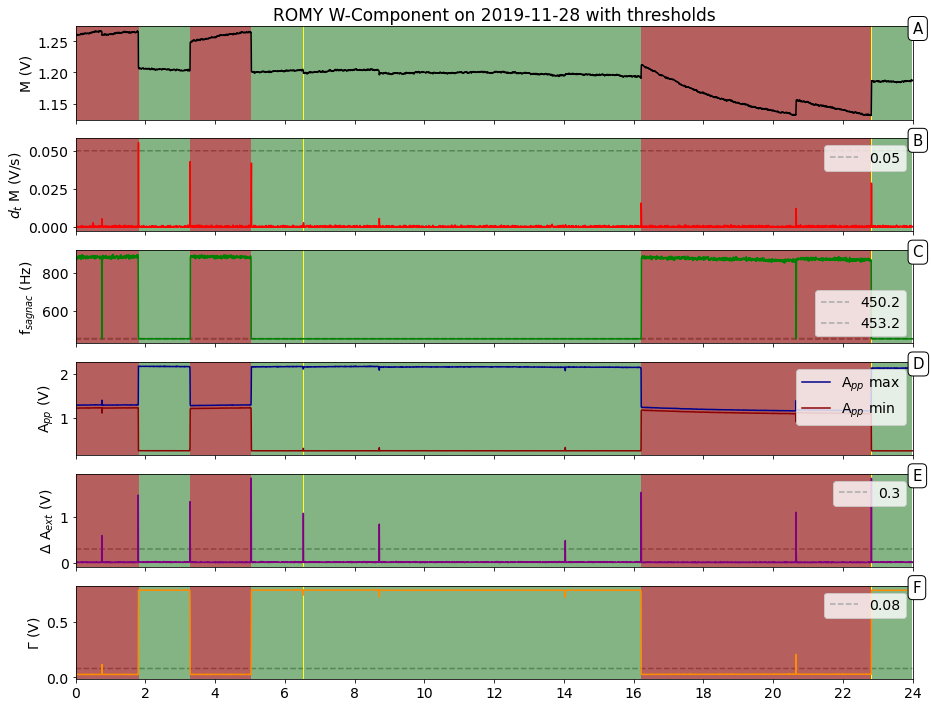

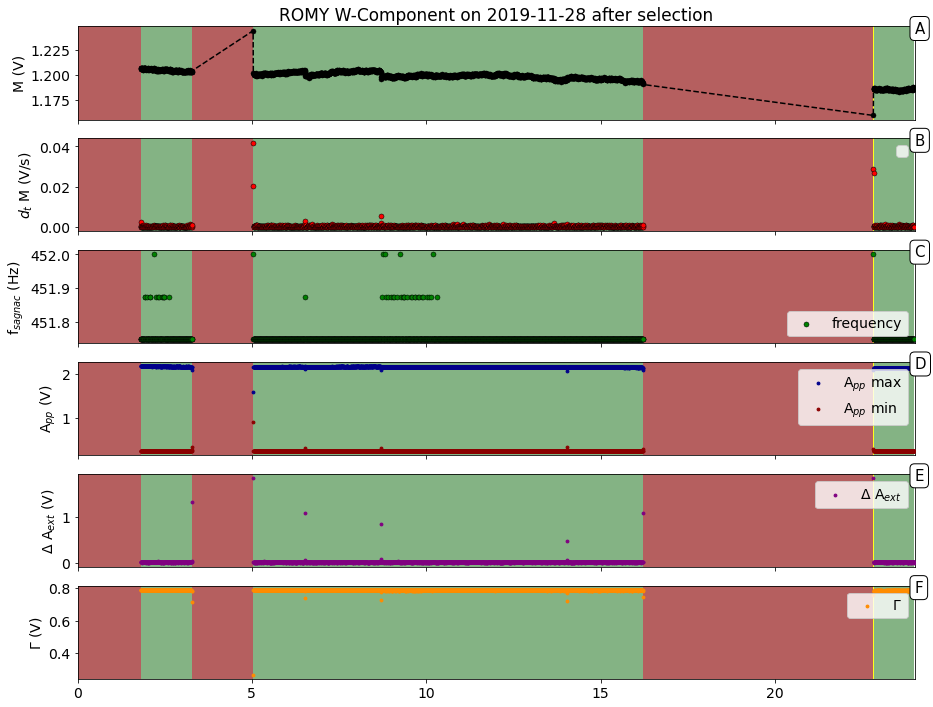

In [14]:
if not sucks:
#     fig1 = __plot_quality(data, data_quality, criteria=True, limit=False)
    fig1 = __plot_quality_V2(data, data_quality, criteria=True, limit=False)
    
    if len(data_select) > 1:
#         fig2 = __plot_quality(data_select, data_quality, criteria=False, limit=True)
        fig2 = __plot_quality_V2(data_select, data_quality, criteria=False, limit=True)


### Saving figures

In [15]:

if not sucks:
    if not os.path.isdir(opathfigs):
        os.mkdir(opathfigs)

    if len(data_select) > 1:
        try:
            __savefig(fig1, outpath=opathfigs, outname=onamefigs+"(1).png", mode="png") 
            __savefig(fig2, outpath=opathfigs, outname=onamefigs+"(2).png", mode="png") 

#             __save_to([fig1, fig2], outpath=opathfigs, outname=onamefigs, mode="pdf")
        except:
            print("saving figures skipped")
    
    else:
        try:
            __savefig(fig1, outpath=opathfigs, outname=onamefigs, mode="png") 
#             __save_to(fig1, outpath=opathfigs, outname=onamefigs, mode="pdf") 
        except:
            print("saving figures skipped")            
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/andbro/Documents/ROMY/QualityCheck/runw/QPlots/2019-11/BJW/'

### manually saving

In [ ]:
## from andbro__savefig import __savefig
    
# __savefig(fig1, outpath="/home/brotzer/Desktop/", outname=f"Quality_{date_to_analyse.date}.png", mode="png")

## 